# **`SEPSIS PREDICTOR`**

 ## **`1. Business Understanding`**

 ### What is Sepsis?
 - Sepsis is your body’s extreme reaction to an infection. When you have an infection, your immune system works to try to fight it. But sometimes your immune system stops fighting the infection and starts damaging your normal tissues and organs, leading to widespread inflammation throughout your body.  
 
 - This extensive inflammation throughout your body that can lead to tissue damage, organ failure and even death. Many different kinds of infections can trigger sepsis, which is a medical emergency. The quicker you receive treatment, the better your outcome will be.

### Goal
 - The goal is to develop a predictive model that can help identify patients at risk of developing sepsis within 24 hours of their admission to the intensive care unit (ICU).

 ### Hypothesis
 **Null Hypotheisi (H0)**  - There is no significant correlation between blood pressure and sepsis  
 **Alternative Hypothesis (H1)** - There is a significant correlation between blood pressure and sepsis

 ### Analytical Questions
 
 1. Is there a significant correlation between age and the likelihood of developing sepsis?
 2. What is the relationship between blood pressure (PR) and the incidence of sepsis?
 3. What is the relationship between body mass index (BMI) and the development of sepsis? & What is the average Body mass index among patients who develop sepsis and who do not?
 4. How is the distribution of plasma glucose (PRG) among patients who develop sepsis versus those who don't?
 5. Which blood work parameters (PL, SK, TS, BD2) are most strongly associated with the development of sepsis?

## **`2. Data Understanding`**


*************************************
* **About the Data**                 *
*************************************
* **ID**: number to represent patient ID *
* **PRG**: Plasma glucose           *
* **PL**: Blood Work Result-1 (mu U/ml) *
* **PR**: Blood Pressure (mm Hg)    *
* **SK**: Blood Work Result-2 (mm)  *
* **TS**: Blood Work Result-3 (mu U/ml) *
* **M11**: Body mass index (weight in kg/(height in m)^2) *
* **BD2**: Blood Work Result-4 (mu U/ml) *
* **Age**: patients age (years)     *
* **Insurance**: If a patient holds a valid insurance card *
* **Sepsis**: Positive: if a patient in ICU will develop a sepsis, and Negative: otherwise *
*************************************


In [234]:
# Import Libraries
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE


# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')


In [171]:
# Load data
df = pd.read_csv("Sepsis Data\Paitients_Files_Train.csv")

In [172]:
df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


### **`EXPLORATORY DATA ANALYSIS (EDA)`**

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [174]:
# Check for null values
df.isnull().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

In [175]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

In [176]:
# Describe the dataset 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PRG,599.0,3.824708,3.362839,0.000,1.000,3.000,6.000,17.00
PL,599.0,120.153589,32.682364,0.000,99.000,116.000,140.000,198.00
PR,599.0,68.732888,19.335675,0.000,64.000,70.000,80.000,122.00
SK,599.0,20.562604,16.017622,0.000,0.000,23.000,32.000,99.00
TS,599.0,79.460768,116.576176,0.000,0.000,36.000,123.500,846.00
M11,599.0,31.920033,8.008227,0.000,27.100,32.000,36.550,67.10
BD2,599.0,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,33.290484,11.828446,21.000,24.000,29.000,40.000,81.00
Insurance,599.0,0.686144,0.464447,0.000,0.000,1.000,1.000,1.00


### **Univariate Analysis**

In [177]:
# Describe the diagnosis column
df['Sepssis'].describe()

count          599
unique           2
top       Negative
freq           391
Name: Sepssis, dtype: object

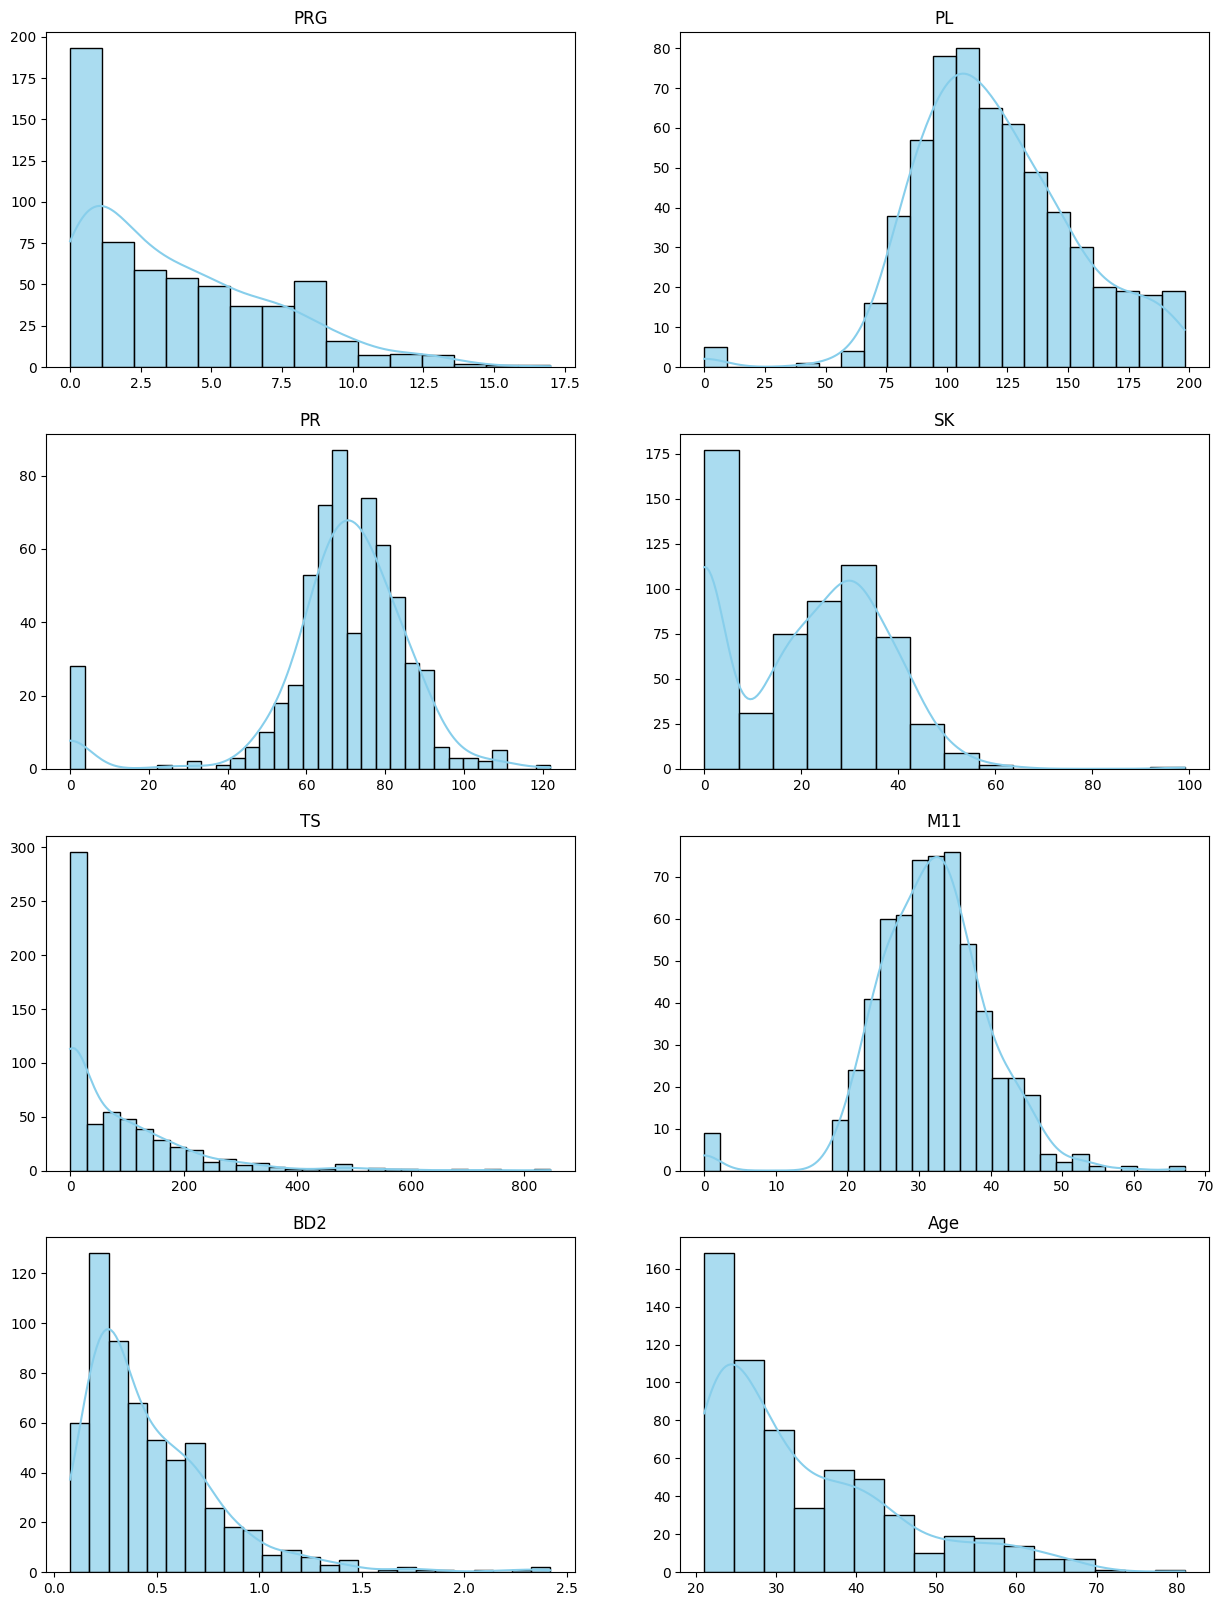

In [178]:
# Histplots to show distributions of data
num_rows, num_cols = 4, 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

for i, column in enumerate(df.drop(['ID', 'Insurance', 'Sepssis'], axis=1).columns):
    row, col = i // num_cols, i % num_cols
    sns.histplot(df[column], ax=axes[row, col], color='skyblue', kde=True, alpha=0.7, label='Skewness') 
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("")

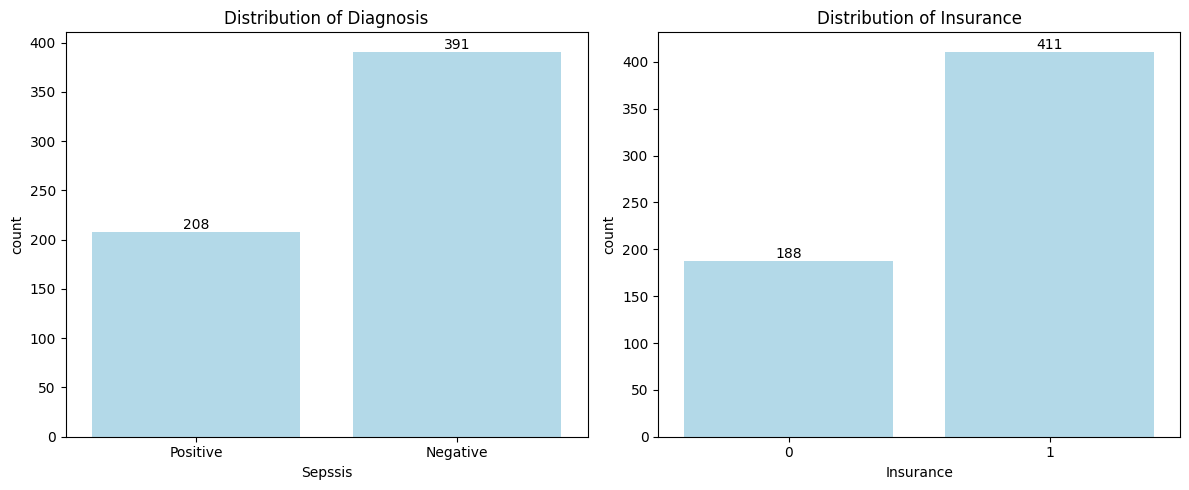

In [179]:
# Countplots to show distributions of Dianosis and Insurance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First plot: Distribution of Diagnosis
sns.countplot(x='Sepssis', data=df, ax=axes[0], color='skyblue', alpha=0.7)
axes[0].set_title('Distribution of Diagnosis')
for i in axes[0].containers:
    axes[0].bar_label(i,)

# Second plot: Distribution of Diagnosis with respect to Insurance
sns.countplot(x='Insurance', data=df, ax=axes[1], color='skyblue', alpha=0.7)
axes[1].set_title('Distribution of Insurance')
for i in axes[1].containers:
    axes[1].bar_label(i,)

# Adjust layout
plt.tight_layout()
plt.show()


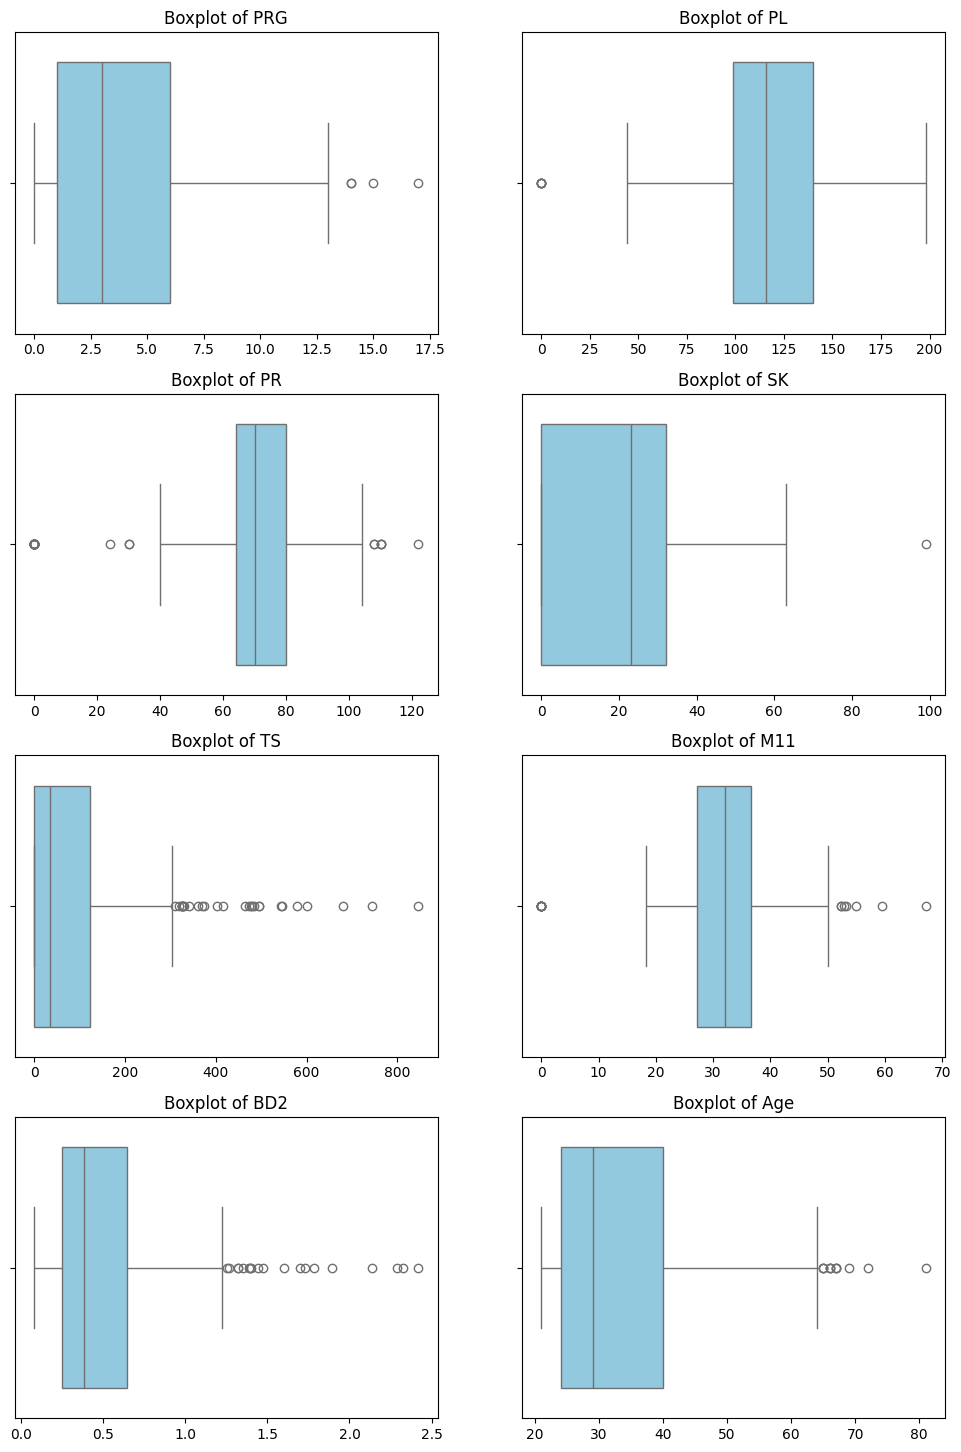

In [180]:
# Boxplots to show any outliers in the numerical columns
fig, ax = plt.subplots(4, 2, figsize=(12,18))

# Get numerical columns
num_cols = df.drop(['ID', 'Insurance'], axis=1).select_dtypes(include='number').columns

# Iterate over numerical columns
for i, column in enumerate(num_cols):
    row, col = i // 2, i % 2
    sns.boxplot(x=column, data=df, ax=ax[row, col], color='skyblue')
    ax[row, col].set_title(f'Boxplot of {column}')
    ax[row, col].set_xlabel("")
    

## Notes
- The dataset contains 11 columns and 599 rows
- There are no null values in the dataset
- There are no duplicated values in the dataset
- The top outcome is negative with a frequency of 391 against positive at 208
- Most of the blood work results (BD2, SK and Ts) assume a positive skewness. Only Blood work result-1 that assumes a negative skewness
- Body Mass Index (M11) is more normally distributed than not
- Plasma Glucose (PRG) is positively skewed
- Most patients turn negative to sepsis than postive
- Age is postively skewed, Number of patients decreases with increase in age
- Lasty, most patients have an insurance cover with most(411) having a cover against those without(188)
- Most of the numerical columns have outlier values

#### **Bivariate Analysis**

### **Analytical Questions**

### 1. Is there a significant correlation between age and the likelihood of developing sepsis?


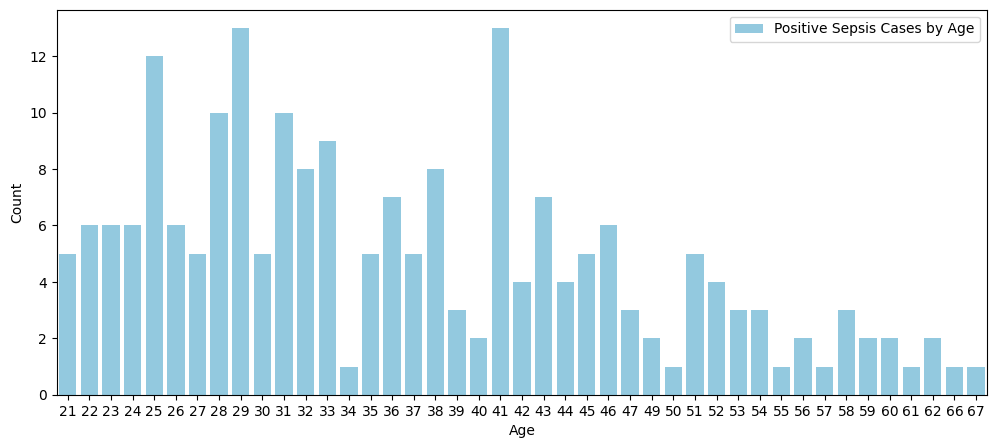

In [181]:
# Barplot to show relationship between age and the likelihood of developing sepsis
plt.figure(figsize=(12, 5)) 
positive_sepsis_by_age = df[df['Sepssis'] == 'Positive'].groupby('Age').size().reset_index(name='Count')
ax = sns.barplot(positive_sepsis_by_age, x='Age', y='Count', label='Positive Sepsis Cases by Age', color='skyblue')

### Notes
- There isn't any obvious Increase or decrease in the number of more postives as age increases. However, there are more postives between age 21 and 33, followed by ages 34 to 49 and the least number of postives comes from ages 50 and above
- We will have to narrow the ages to age groups for the trend to come out more clearly

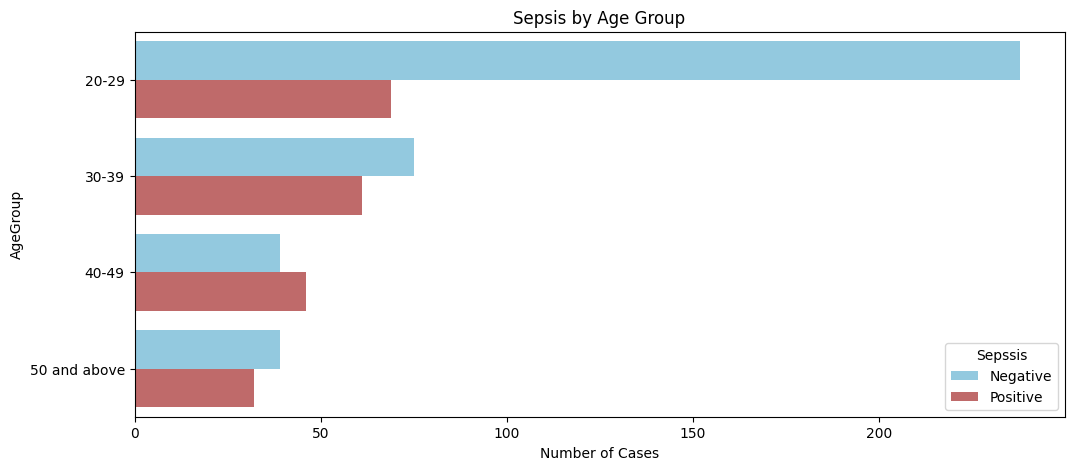

In [182]:
# Define age bins and labels
bins = [20, 30, 40, 50, float('inf')]
labels = ['20-29', '30-39', '40-49', '50 and above']

# Copy the df
df_copy = df.copy()

# Create age groups
df_copy['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
age_group_sepsis = df_copy.groupby(['AgeGroup', 'Sepssis'])['Sepssis'].size().reset_index(name='Number of Cases')

# PLot the grouped data
plt.figure(figsize=(12, 5))
sns.barplot(x='Number of Cases', y='AgeGroup', hue='Sepssis', data=age_group_sepsis, palette=['skyblue', 'indianred'],)
plt.title('Sepsis by Age Group')
plt.show()


### Notes
- When grouped with age groups, a trend becomes more obvious. An increase in age results to an decrease in number of positives
- There we can conclude that the younger a patients is, the more likely they are to develop Sepsis



### 2.  What is the relationship between blood pressure (PR) and the incidence of sepsis?


<Axes: xlabel='PR', ylabel='Count'>

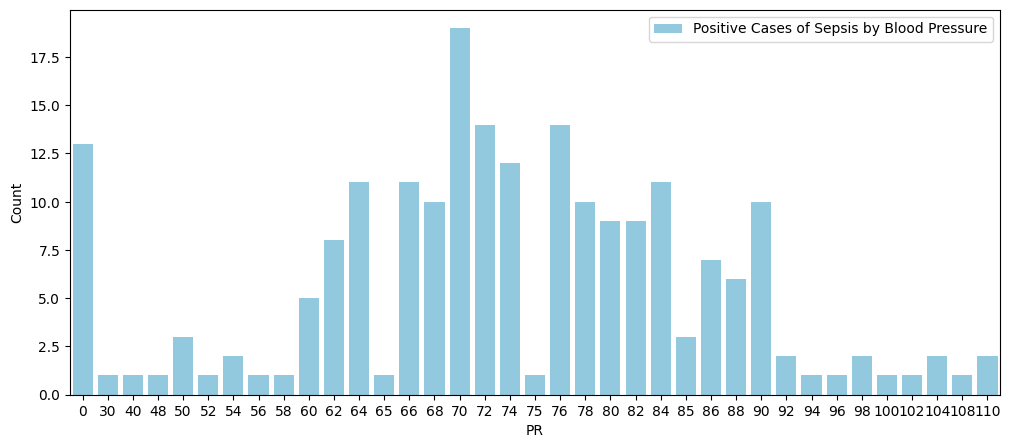

In [183]:
# Barplot to show how Blood pressure correlates to positive cases of sepssis
pr_sepsis = df[df['Sepssis']=='Positive'].groupby('PR')['Sepssis'].count().reset_index(name='Count')
plt.figure(figsize=(12,5))
sns.barplot(pr_sepsis, x='PR', y='Count', label='Positive Cases of Sepsis by Blood Pressure', color='skyblue')

### Notes
- Most positive cases come from the blood pressure of 0 and 70 (mm Hg).
- However most positive cases come from the blood pressure of range 60 (mm Hg) to 90 (mm Hg) with an exception of 65 75 and 85 (mm Hg) which have relatively few numbers of postive case

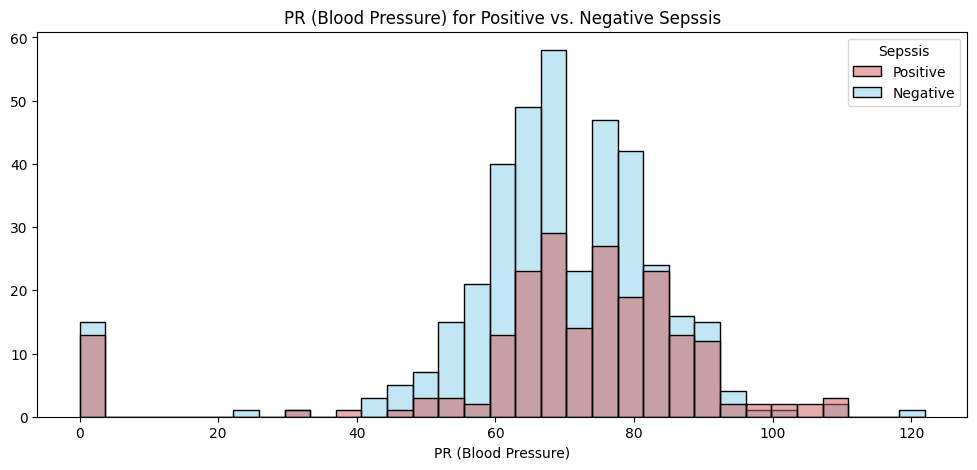

In [184]:
# Comparison of totals cases per PR reading against number of postive cases
# Create the histoplot
plt.figure(figsize=(12,5))
sns.histplot(hue='Sepssis', x='PR', data=df, fill=True, palette=['indianred', 'skyblue'])

# Label the axes
plt.ylabel('')
plt.xlabel('PR (Blood Pressure)')

# Show the plot
plt.title('PR (Blood Pressure) for Positive vs. Negative Sepssis')
plt.show()

### Notes
- After comparing positive and negative cases using a histoplot, we can conclude that infact, most postive cases come from 0 and the ranges of 60 to 90 (mm Hg)

### 3. What is the relationship between body mass index (BMI) and the development of sepsis? & What is the average Body mass index among patients who develop sepsis and who do not?

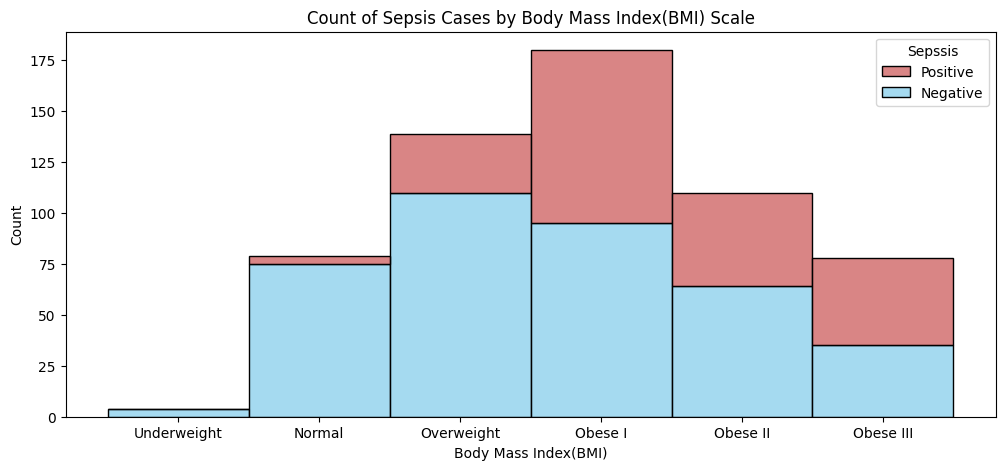

In [185]:
# Histplot to show the correlation between Body Mass Index (BMI) and the development	sepsis
df_copy['BMI'] = pd.cut(df['M11'], 
                              bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
                                    labels=['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II', 'Obese III'])

plt.figure(figsize=(12, 5))
sns.histplot(x='BMI', hue='Sepssis', data=df_copy, multiple='stack', palette=['indianred', 'skyblue'])

# Set labels and title
plt.xlabel('Body Mass Index(BMI)')
plt.ylabel('Count')
plt.title('Count of Sepsis Cases by Body Mass Index(BMI) Scale')

# Show the plot
plt.show()

In [186]:
# Average BMI for positive and negative sepsis cases

# Positive
# Assuming df_copy is your DataFrame
positive_sepsis_bmi_mean = df_copy[df_copy['Sepssis'] == 'Positive']['M11'].mean()

# Negative
negative_sepsis_bmi_mean = df_copy[df_copy['Sepssis'] == 'Negative']['M11'].mean()


print("Mean BMI for Positive Sepsis:", positive_sepsis_bmi_mean)
print("Mean BMI for Negative Sepsis:", negative_sepsis_bmi_mean)



Mean BMI for Positive Sepsis: 35.385576923076925
Mean BMI for Negative Sepsis: 30.076470588235292


### Notes:

- Majority of people who develop sepsis are overweight, and obese (All categories of obesity)

- The mean Body Mass Index (BMI) for positive cases is 35.4 while for negative cases is 30.1. Therefore it's safe to conclude that the higher the BMI the higher the chances of developing Sepsis

### 4. How is the distribution of plasma glucose (PRG) among patients who develop sepsis versus those who don't?


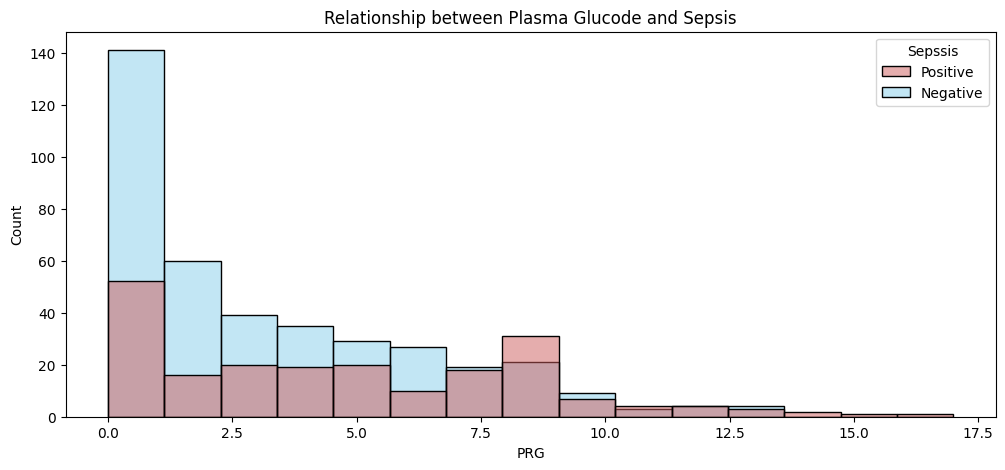

In [187]:
# Histoplot to show the relationship between Plasma Glucode (PRG) and Sepsis
plt.figure(figsize=(12, 5))
sns.histplot(x='PRG', hue='Sepssis', palette=['indianred', 'skyblue'], data=df)
plt.title('Relationship between Plasma Glucode and Sepsis')
plt.show()

### Notes:

- There is a clear correlation: higher plasma glucose levels (PRG) tend to coincide with a higher rate of sepsis positivity.
- Patients with elevated plasma glucose levels (PRG) are more likely to test positive for sepsis compared to those with lower PRG readings.
- These observations underscore the relationship between plasma glucose levels and sepsis positivity, highlighting the potential significance of PRG levels in sepsis diagnosis.

### 5. Which blood work parameters (PL, SK, TS, BD2) are most strongly associated with the development of sepsis?


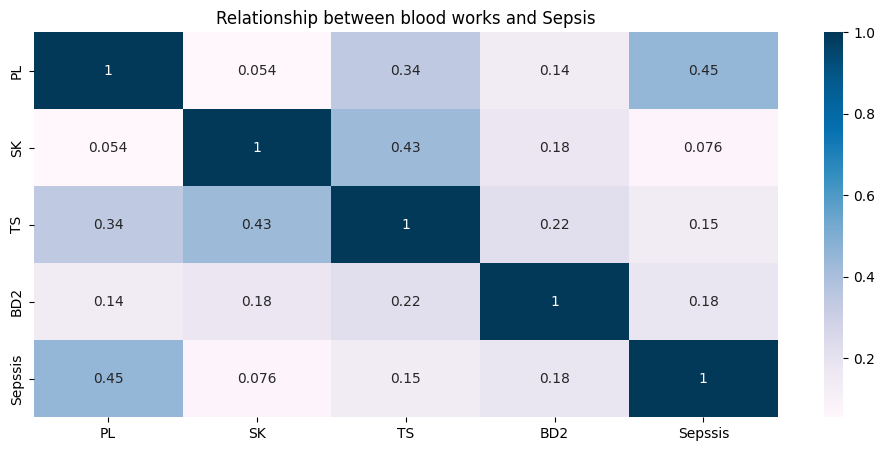

In [188]:
# Heatmap to show correlation between the parameters and sepsis development
df_copy['Sepssis'] = df_copy['Sepssis'].replace({'Positive' : 1, 'Negative': 0})

plt.figure(figsize=(12, 5))
sns.heatmap(df_copy.drop(['ID', 'PRG',  'PR','M11', 'Age', 'Insurance', 'AgeGroup', 'BMI'], axis=1).corr(), annot=True, cmap='PuBu')
plt.title('Relationship between blood works and Sepsis')
plt.show()



### Notes:

- Sepsis is mostly correlated with TS (Blood Work Result-3 (mu U/ml)) with a correlation of 0.45

- Second is PL (Blood Work Result-1 (mu U/ml)) With 0.34

- Third is BD2 (Blood Work Result-4 (mg/dl)) with 0.18

- And the least is SK (Blood Work Result-2 (mu U/ml)) with 0.076

Since using correlation matrix we can only infer much about the general correlation, we will narrow down the corretion using histplots to see how the parameters

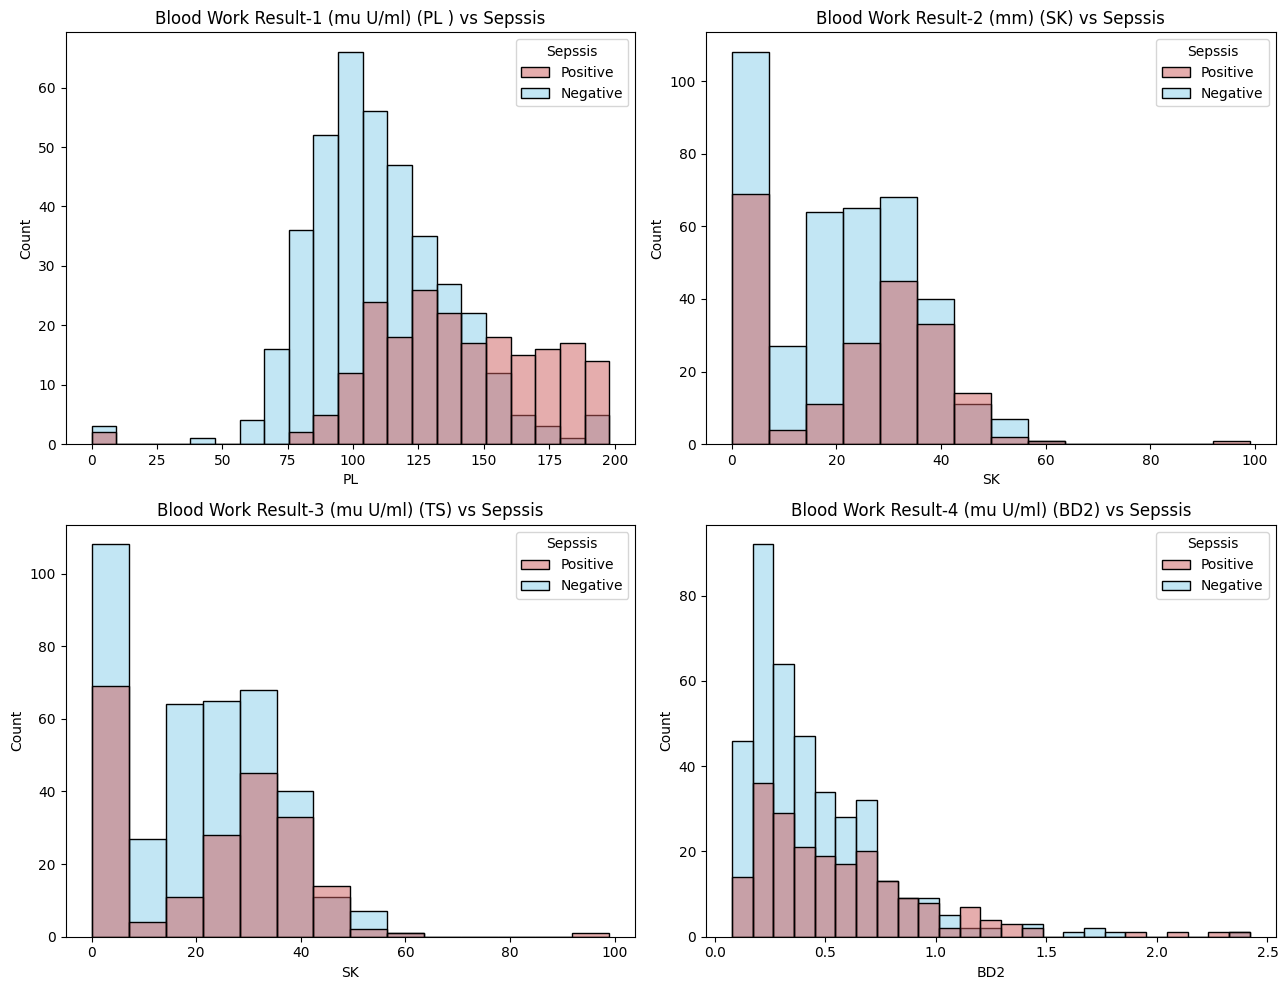

In [189]:
# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(13, 10))

# Create the strip plots
sns.histplot(ax=axes[0, 0], hue='Sepssis', x='PL', data=df, fill=True, palette=['indianred', 'skyblue'])
sns.histplot(ax=axes[0, 1], hue='Sepssis', x='SK', data=df, fill=True, palette=['indianred', 'skyblue'])
sns.histplot(ax=axes[1, 0], hue='Sepssis', x='SK', data=df, fill=True, palette=['indianred', 'skyblue'])
sns.histplot(ax=axes[1, 1], hue='Sepssis', x='BD2', data=df, fill=True, palette=['indianred', 'skyblue'])

# Set titles for each subplot
axes[0, 0].set_title('Blood Work Result-1 (mu U/ml) (PL ) vs Sepssis')
axes[0, 1].set_title('Blood Work Result-2 (mm) (SK) vs Sepssis')
axes[1, 0].set_title('Blood Work Result-3 (mu U/ml) (TS) vs Sepssis')
axes[1, 1].set_title('Blood Work Result-4 (mu U/ml) (BD2) vs Sepssis')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

### Notes
- The higher the readings of Blood Work Result-1 (mu U/ml) (PL) the more likely that the patient will develop sepsis
- 0 and the ranges of 30 to 50 in Blood Work Result-2 (mm) (SK) and Blood Work Result-3 (mu U/ml) (TS) mostly leads to developments of sepsis more often than other values
- The higher the readings of Blood Work Result-4 (mu U/ml) (BD2), the more likely that the patient will develop sepsis

### Multivariate Analysis

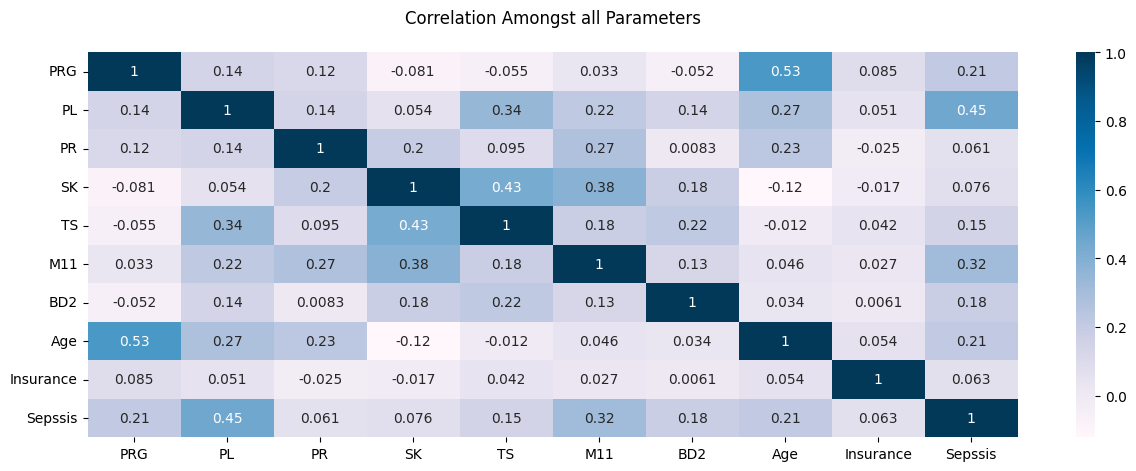

In [190]:
# Heatmap to show correlation of all the parameters
plt.figure(figsize=(15,5))
sns.heatmap(df_copy.drop(['ID', 'AgeGroup', 'BMI'], axis=1).corr(), annot=True, cmap='PuBu')
plt.title("Correlation Amongst all Parameters\n")
plt.show()

### Notes
- The highest correlation is between Plasma Glulose (PRG) AND Sepsis at 0.53
- The second highest correlation is between is between Sepsis and Blood work result 1 (PL)

### **Hypothesis Testing**

**Null Hypotheisi (H0)**  - There is no significant correlation between blood pressure and sepsis  
 **Alternative Hypothesis (H1)** - There is a significant correlation between blood pressure and sepsis

In [191]:
# Calculate the point-biserial correlation
correlation, p_value = pointbiserialr(df_copy['Sepssis'], df_copy['PR'])

print(f'Correlation coefficient: {correlation:.5f}')
print(f'P-value: {p_value:.5f}')

# Interpret the result
alpha = 0.01
if p_value < alpha:
    print("Reject the null hypothesis (H0). \nThere is a correlation between blood pressure (PR) and sepsis.")
else:
    print("Fail to reject the null hypothesis (H0). \nThere is no correlation between blood pressure (PR) and sepsis.")


Correlation coefficient: 0.06109
P-value: 0.13535
Fail to reject the null hypothesis (H0). 
There is no correlation between blood pressure (PR) and sepsis.


### Notes
The point-biserial correlation is used to measure the relationship between a binary variable (x) and a continuous variable (y). Like other correlation coefficients, this one varies between -1 and +1, with 0 implying no correlation. Correlations of -1 or +1 imply a determinative relationship.(A determinative relationship means that one factor directly causes another to happen.)  


In our case, a p-value of 0.13535 implies that there is no significant correlation (Values close to 0 indicate no correlation) between blood pressure (PR) and sepsis. Specifically, because the p-value is greater than the common significance level (alpha = 0.05), we fail to reject the null hypothesis (H0). This means that any observed correlation is likely due to chance rather than a true underlying relationship.

## **`3. Data Preparation`**

In [192]:
# Change Sepssis to Sepsis
df.rename(columns={'Sepssis': 'Sepsis'}, inplace=True)

In [193]:

# Convert Insurance column to categorical

df['Insurance'] = df['Insurance'].replace({0 : 'No', 1 : 'Yes'})

df.drop('ID', axis=1, inplace=True)

#### Data Splitting

In [194]:
# Define X
X = df.drop('Sepsis', axis=1)

# Define y
y = df['Sepsis']

y.head()

0    Positive
1    Negative
2    Positive
3    Negative
4    Positive
Name: Sepsis, dtype: object

In [195]:
# Check the number of values for every class
y.value_counts()

Sepsis
Negative    391
Positive    208
Name: count, dtype: int64

In [196]:
X.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,6,148,72,35,0,33.6,0.627,50,No
1,1,85,66,29,0,26.6,0.351,31,No
2,8,183,64,0,0,23.3,0.672,32,Yes
3,1,89,66,23,94,28.1,0.167,21,Yes
4,0,137,40,35,168,43.1,2.288,33,Yes


### Notes
The classes needs balancing for our models to train on balanced data
- In this case, we will use SMOTE
- One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

In [207]:
# Encode the insurance colum for smoting
X['Insurance'] = X['Insurance'].replace({'No': 0, 'Yes': 1})


In [209]:
# apply SMOTE to the training data (oversampling)

smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy='auto')

X_resampled, y_resampled = smote.fit_resample(X, y)

In [211]:
y_resampled.value_counts()

Sepsis
Positive    391
Negative    391
Name: count, dtype: int64

In [212]:
# Return to the original state for passing through the pipeline
X_resampled['Insurance'] = X_resampled['Insurance'].replace({0: 'No', 1: 'Yes'})

In [213]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [215]:
# Define numerical columns
numerical_columns = X_resampled.select_dtypes(exclude='object').columns

# Define categorical columns
categorical_columns = X_resampled.select_dtypes(include='object').columns

print(f'Numerical Columns: {numerical_columns}')
print(f'Categoriacl Columns: {categorical_columns}')

Numerical Columns: Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age'], dtype='object')
Categoriacl Columns: Index(['Insurance'], dtype='object')


In [216]:
# Initialize the Label Encoder
label_encoder = LabelEncoder()

# Encode y
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [217]:
# Create a numerical pipeline
num_pipeline = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Create a categorical pipeline
cat_pipeline = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_columns),
        ('cat', cat_pipeline, categorical_columns)
    ])

## **`4. Modelling`**

**1.Training Random Forest**

Accuracy : 0.78
              precision    recall  f1-score   support

           0       0.87      0.67      0.76        79
           1       0.73      0.90      0.80        78

    accuracy                           0.78       157
   macro avg       0.80      0.78      0.78       157
weighted avg       0.80      0.78      0.78       157



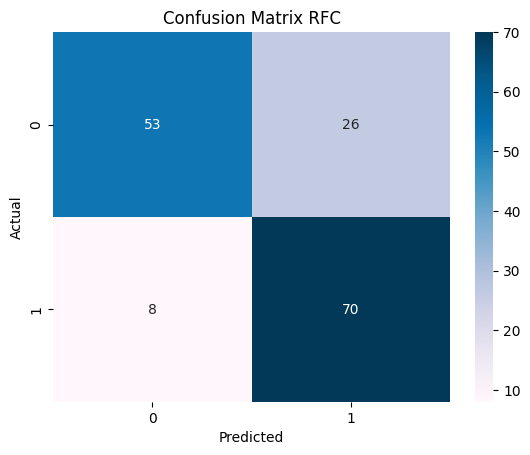

In [218]:

# Initiate RandomForestClassifier
rfc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf_classifier', RandomForestClassifier(max_depth=2, random_state=42))
])

# Train rfc pipeline
rfc_pipeline.fit(X_train, y_train_encoded)

# Predict
y_pred_rfc = rfc_pipeline.predict(X_test)

# Accuracy
rfc_accuracy = round(accuracy_score(y_test_encoded, y_pred_rfc),2)
print(f'Accuracy : {rfc_accuracy}')

# Classification report

print(classification_report(y_test_encoded, y_pred_rfc))

sns.heatmap(confusion_matrix(y_test_encoded, y_pred_rfc), annot=True, cmap='PuBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix RFC')
plt.show()




**2. Training XGClassifier**

Accuracy : 0.81
              precision    recall  f1-score   support

           0       0.87      0.73      0.79        79
           1       0.77      0.88      0.82        78

    accuracy                           0.81       157
   macro avg       0.82      0.81      0.81       157
weighted avg       0.82      0.81      0.81       157



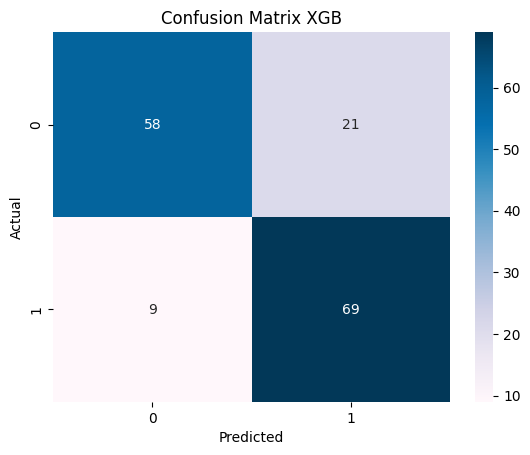

In [219]:
# Training xgb pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb_classifier', XGBClassifier(max_depth=2, random_state=42, n_estimators=100)),
])

xgb_pipeline.fit(X_train, y_train_encoded)

# Predict
y_pred_xgb = xgb_pipeline.predict(X_test)

# Accuracy
xgb_accuracy = round(accuracy_score(y_test_encoded, y_pred_xgb),2)
print(f'Accuracy : {xgb_accuracy}')

# Classification Report
print(classification_report(y_test_encoded, y_pred_xgb))

# Confusion Matrix

sns.heatmap(confusion_matrix(y_test_encoded, y_pred_xgb), annot=True, cmap='PuBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix XGB')
plt.show()


**3. Training Logistic Regressor**

Accuracy : 0.69
              precision    recall  f1-score   support

           0       0.69      0.68      0.69        79
           1       0.68      0.69      0.69        78

    accuracy                           0.69       157
   macro avg       0.69      0.69      0.69       157
weighted avg       0.69      0.69      0.69       157



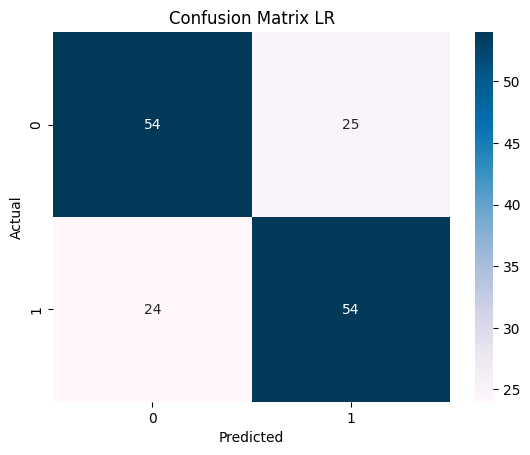

In [220]:
# Training Logistic Regressor
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lr_classifier', LogisticRegression(random_state=0, multi_class='auto'))
])

# Predict

lr_pipeline.fit(X_train, y_train_encoded)

y_pred_lr = lr_pipeline.predict(X_test)

# Accuracy
lr_accuracy = round(accuracy_score(y_test_encoded, y_pred_lr),2)
print(f'Accuracy : {lr_accuracy}')

# Classification Report
print(classification_report(y_test_encoded, y_pred_lr))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_encoded, y_pred_lr), annot=True, cmap='PuBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix LR')
plt.show()

**4. Training SVC**

Accuracy : 0.81
              precision    recall  f1-score   support

           0       0.87      0.73      0.79        79
           1       0.77      0.88      0.82        78

    accuracy                           0.81       157
   macro avg       0.82      0.81      0.81       157
weighted avg       0.82      0.81      0.81       157



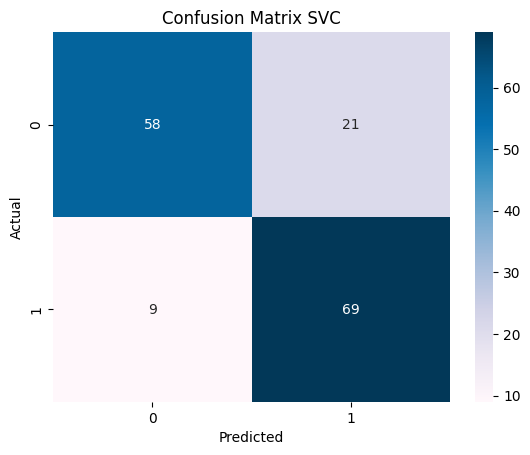

In [221]:
# Training xgb pipeline
svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SVC', SVC(random_state=0, gamma='auto'))
])

svc_pipeline.fit(X_train, y_train_encoded)

# Predict
y_pred_svc = xgb_pipeline.predict(X_test)

# Accuracy
svc_accuracy = round(accuracy_score(y_test_encoded, y_pred_svc),2)
print(f'Accuracy : {svc_accuracy}')

# Classification Report
print(classification_report(y_test_encoded, y_pred_svc))

# Confusion Matrix

sns.heatmap(confusion_matrix(y_test_encoded, y_pred_svc), annot=True, cmap='PuBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix SVC')
plt.show()


**5. Training GradientBoostingClassifier**

Accuracy : 0.76
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        79
           1       0.74      0.82      0.78        78

    accuracy                           0.76       157
   macro avg       0.77      0.76      0.76       157
weighted avg       0.77      0.76      0.76       157



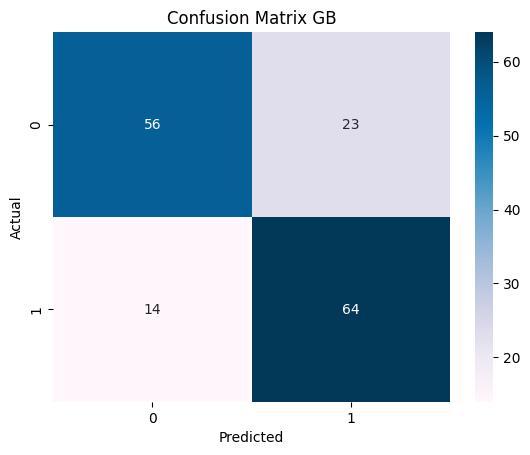

In [222]:
# Training GradientBoostingClassifier

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gb_classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0))
])

gb_pipeline.fit(X_train, y_train_encoded)

# Predict
y_pred_gb = gb_pipeline.predict(X_test)

# Accuracy
gb_accuracy = round(accuracy_score(y_test_encoded, y_pred_gb),2)
print(f'Accuracy : {gb_accuracy}')

# Classification Report
print(classification_report(y_test_encoded, y_pred_gb))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_encoded, y_pred_gb), annot=True, cmap='PuBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix GB')
plt.show()


6. **Training KNEIGHBOURS**

Accuracy : 0.8
              precision    recall  f1-score   support

           0       0.85      0.72      0.78        79
           1       0.76      0.87      0.81        78

    accuracy                           0.80       157
   macro avg       0.80      0.80      0.80       157
weighted avg       0.80      0.80      0.80       157



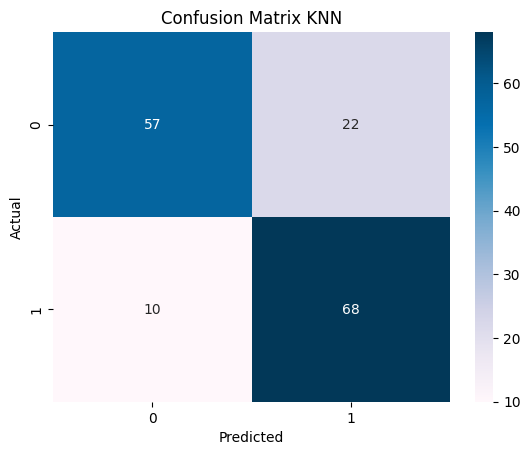

In [228]:
# Training KNEIGHBOURS
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn_classifier', KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train_encoded)

# Predict
y_pred_knn = knn_pipeline.predict(X_test)

# Accuracy
knn_accuracy = round(accuracy_score(y_test_encoded, y_pred_knn),2)
print(f'Accuracy : {knn_accuracy}')

# Classification Report
knn_classification_report = classification_report(y_test_encoded, y_pred_knn)
print(f'{knn_classification_report}')

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_encoded, y_pred_knn), annot=True, cmap='PuBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix KNN')
plt.show()

## **`5. Models Evaluation`**

In [224]:
# Model Accuracies
models = {
    'Random Forest': rfc_accuracy,
    'XGBoost': xgb_accuracy,
    'Logistic Regression': lr_accuracy,
    'SVC': svc_accuracy,
    'Gradient Boosting': gb_accuracy,
    'KNeighbors': knn_accuracy
}

# Create a DataFrame from the dictionary
df_models = pd.DataFrame(list(models.items()), columns=['Model', 'Accuracy'])

# Sort the DataFrame by the 'Accuracy' column in descending order
df_sorted = df_models.sort_values(by='Accuracy', ascending=False)

df_sorted

,Model,Accuracy
1,XGBoost,0.81
3,SVC,0.81
5,KNeighbors,0.80
0,Random Forest,0.78
4,Gradient Boosting,0.76
2,Logistic Regression,0.69


In [225]:
# Model Precision, Recall, and F1-Score
models_metrics = {
    'Random Forest': precision_recall_fscore_support(y_test_encoded, y_pred_rfc, average='weighted'),
    'XGBoost': precision_recall_fscore_support(y_test_encoded, y_pred_xgb, average='weighted'),
    'Logistic Regression': precision_recall_fscore_support(y_test_encoded, y_pred_lr, average='weighted'),
    'SVC': precision_recall_fscore_support(y_test_encoded, y_pred_svc, average='weighted'),
    'Gradient Boosting': precision_recall_fscore_support(y_test_encoded, y_pred_gb, average='weighted'),
    'KNeighbors': precision_recall_fscore_support(y_test_encoded, y_pred_knn, average='weighted')
}

# Extracting the relevant metrics
metrics_df = pd.DataFrame(models_metrics, index=['Precision', 'Recall', 'F1-Score', 'Support']).T.drop(columns=['Support'])

# Display the DataFrame
metrics_df.sort_values(by='Precision', ascending=False)	

,Precision,Recall,F1-Score
XGBoost,0.816484,0.808917,0.807889
SVC,0.816484,0.808917,0.807889
KNeighbors,0.803454,0.796178,0.795081
Random Forest,0.799454,0.783439,0.780719
Gradient Boosting,0.768021,0.764331,0.763641
Logistic Regression,0.687954,0.687898,0.687898


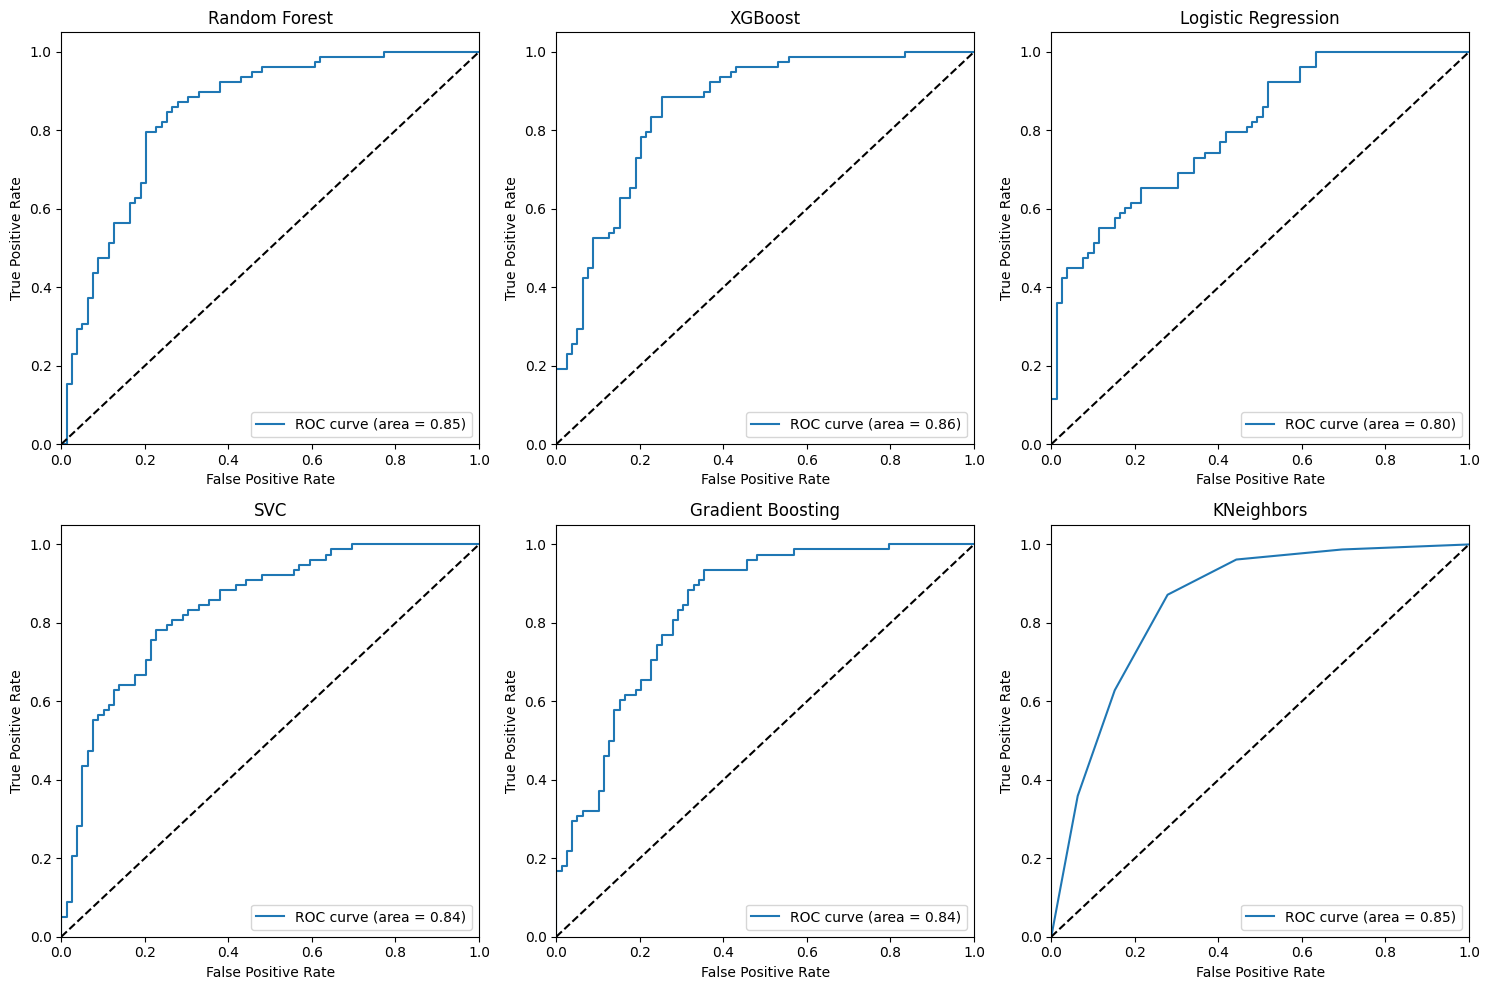

In [226]:
# Generate predicted probabilities
y_pred_proba_rfc = rfc_pipeline.predict_proba(X_test)
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)
y_pred_proba_lr = lr_pipeline.predict_proba(X_test)
y_pred_proba_svc = svc_pipeline.decision_function(X_test)  # SVC uses decision_function
y_pred_proba_gb = gb_pipeline.predict_proba(X_test)
y_pred_proba_knn = knn_pipeline.predict_proba(X_test)

# Store predicted probabilities in a dictionary
models_probas = {
    'Random Forest': y_pred_proba_rfc,
    'XGBoost': y_pred_proba_xgb,
    'Logistic Regression': y_pred_proba_lr,
    'SVC': y_pred_proba_svc,
    'Gradient Boosting': y_pred_proba_gb,
    'KNeighbors': y_pred_proba_knn
}

# Dictionaries to hold false positive rates, true positive rates, and ROC AUC scores
fpr = {}
tpr = {}
roc_auc = {}

# Calculate ROC curve data for each model
for model in models_probas:
    if model == 'SVC':
        # For SVC, we use decision function scores directly
        fpr[model], tpr[model], _ = roc_curve(y_test_encoded, models_probas[model])
    else:
        # For other models, we use the predicted probabilities of the positive class
        fpr[model], tpr[model], _ = roc_curve(y_test_encoded, models_probas[model][:, 1])
    roc_auc[model] = auc(fpr[model], tpr[model])

# Plot ROC curves in a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axs array to easily iterate over it
axs = axs.flatten()

# Plot each model's ROC curve
for i, model in enumerate(models_probas):
    axs[i].plot(fpr[model], tpr[model], label=f'ROC curve (area = {roc_auc[model]:.2f})')
    axs[i].plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].set_title(model)
    axs[i].legend(loc="lower right")

plt.tight_layout()  
plt.show()  

### Notes

- I'm focusing on refining three key models— **XGBoost, SVC (Support Vector Classifier), and KNeighbors** to improve their ability to predict sepsis accurately. 
- XGBoost has shown the highest AUC ROC score of 0.856, indicating it's very good at distinguishing between sepsis and non-sepsis cases. 
- For SVC, which also performs well with an AUC ROC score of 0.840, I'll be tweaking settings like kernel types and regularization to enhance its accuracy. 
- KNeighbors, with an accuracy of 0.80 and an AUC ROC of 0.849, will benefit from adjustments to the number of neighbors and distance calculations to boost its predictive power. 
- My approach involves carefully adjusting these models using methods like grid search and cross-validation to ensure they perform reliably in identifying sepsis cases.

**`Hyperparameter Tuning`**

**1 Tuning XGBClassifier**

In [243]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'xgb_classifier__max_depth': [3, 5, 7, 10],
    'xgb_classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb_classifier__subsample': [0.5, 0.7, 1],
    'xgb_classifier__colsample_bytree': [0.5, 0.7, 1],
    'xgb_classifier__gamma': [0, 0.1, 0.2],
    'xgb_classifier__min_child_weight': [1, 3, 5]
}


# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train_encoded)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best set of hyperparameters:  {'xgb_classifier__colsample_bytree': 0.5, 'xgb_classifier__gamma': 0, 'xgb_classifier__learning_rate': 0.1, 'xgb_classifier__max_depth': 7, 'xgb_classifier__min_child_weight': 3, 'xgb_classifier__subsample': 1}
Best score:  0.8240000000000001


In [250]:
# Save the tuned model
tuned_xgb_pipeline = grid_search.best_estimator_

# Fit the Model
tuned_xgb_pipeline.fit(X_train, y_train_encoded)

# Predict
y_pred_tuned_xgb = tuned_xgb_pipeline.predict(X_test)

# Compute accuracies
tuned_xgb_accuracy = accuracy_score(y_test_encoded, y_pred_tuned_xgb)

# Create DataFrame with accuracy scores
accuracy_df = pd.DataFrame({
    'Accuracy': [xgb_accuracy, tuned_xgb_accuracy],
    'Model': ['Original XGBoost', 'Tuned XGBoost']
})

accuracy_df.set_index('Model', inplace=True)
accuracy_df.columns.name = 'Accuracy Scores'
accuracy_df

Accuracy Scores,Accuracy
Model,
Original XGBoost,0.808917
Tuned XGBoost,0.808917


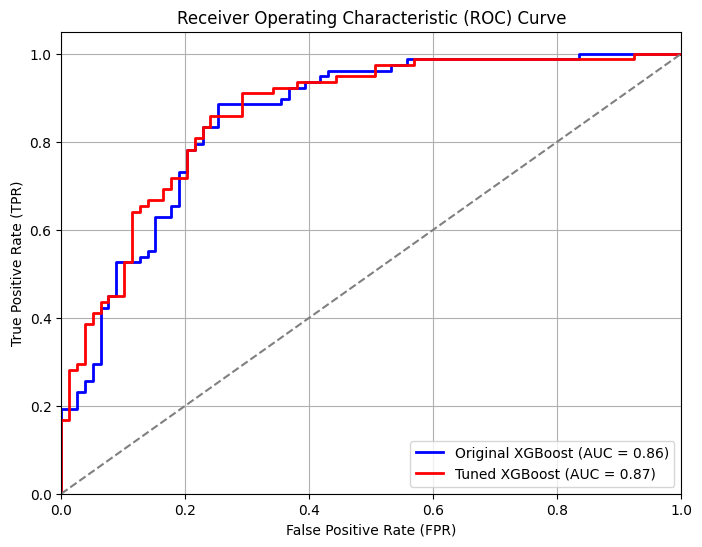

In [251]:
# Predict probabilities for the original XGBoost pipeline
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for the original XGBoost pipeline
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_encoded, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Predict probabilities for the tuned XGBoost pipeline
y_pred_proba_tuned_xgb = tuned_xgb_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for the tuned XGBoost pipeline
fpr_tuned_xgb, tpr_tuned_xgb, _ = roc_curve(y_test_encoded, y_pred_proba_tuned_xgb)
roc_auc_tuned_xgb = auc(fpr_tuned_xgb, tpr_tuned_xgb)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'Original XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_tuned_xgb, tpr_tuned_xgb, color='red', lw=2, label=f'Tuned XGBoost (AUC = {roc_auc_tuned_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Notes:
After fine-tuning both the original and tuned XGBoost models, the tuned model demonstrated a significant improvement in the Area Under the ROC Curve (AUC), achieving 87% compared to 86% with the original model. This enhancement indicates that the parameters adjusted during tuning, have effectively optimized the model's ability to accurately predict sepsis cases in my dataset. Given the improved AUC, I am confident in selecting the tuned XGBoost model for deployment.